In [1]:
# Install necessary packages to Project environment in terminal
# Check that they have been precompiled by running the following:
using Pkg;Pkg.status()

      Status `~/work/washington/jup_moons/Project.toml`
  [1537fe66] CALCEPH v1.1.0 `~/.julia/dev/CALCEPH`
  [7073ff75] IJulia v1.23.3
  [42fd0dbc] IterativeSolvers v0.9.2
  [438e738f] PyCall v1.94.1
  [d330b81b] PyPlot v2.11.0
  [5bab7191] SPICE v0.2.2
  [d84f081e] TTVFaster v0.1.1
  [8bb1440f] DelimitedFiles
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [10745b16] Statistics


In [2]:
include("sim_times.jl")

plot_orbits (generic function with 1 method)

Integrate orbits from JPL Epheremis

In [3]:
nyear=10
jd_start=2443000.0; 
jd_end=jd_start + nyear*365.25; 
jdsize=100
times=range(jd_start, stop=jd_end, length=jdsize)
AU = 149597870.700 #km
# dt = (jd2 - jd1)/jdsize
# @assert (jd_start >= 2287184.5) #2414105.0
# @assert (jd_end <= 2688976.5) #2488985.0

# Compute ephemerides (positions, velocities, and accelerations) of Jupiter, and its Galilean Moons:
# positions = pva[1:3] ; velocities = pva[4:6]; accel = pva[6:9]
pva_JUP = zeros(9,jdsize)
pva_IO = zeros(9,jdsize)
pva_EUR = zeros(9,jdsize)
pva_GAN = zeros(9,jdsize)
pva_CAL = zeros(9,jdsize)
for i=1:length(times)
    pva_IO[1:9,i] = compute(eph,times[i],0.0,naifId.id[:io],naifId.id[:jupiter],options,2)./AU
    pva_EUR[1:9,i] = compute(eph,times[i],0.0,naifId.id[:europa],naifId.id[:jupiter],options,2)./AU
    pva_GAN[1:9,i] = compute(eph,times[i],0.0,naifId.id[:ganymede],naifId.id[:jupiter],options,2)./AU
    pva_CAL[1:9,i] = compute(eph,times[i],0.0,naifId.id[:callisto],naifId.id[:jupiter],options,2)./AU
end

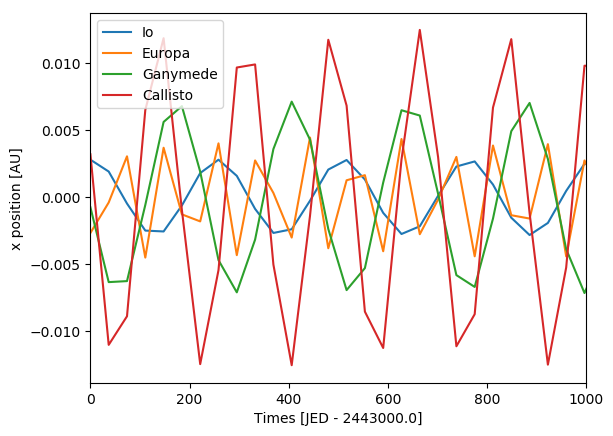

PyObject <matplotlib.legend.Legend object at 0x7f7c9ee55fd0>

In [6]:
using PyPlot
# figure(figsize=(8,6))
plot(collect(times).-times[1],pva_IO[1,:],label="Io")
plot(collect(times).-times[1],pva_EUR[1,:],label="Europa")
plot(collect(times).-times[1],pva_GAN[1,:],label="Ganymede")
plot(collect(times).-times[1],pva_CAL[1,:],label="Callisto")
xlabel("Times [JED - 2443000.0]")
ylabel("x position [AU]")
xlim(0,1000)
legend()

Find the observer location required to see Io and Europa transiting Jupiter

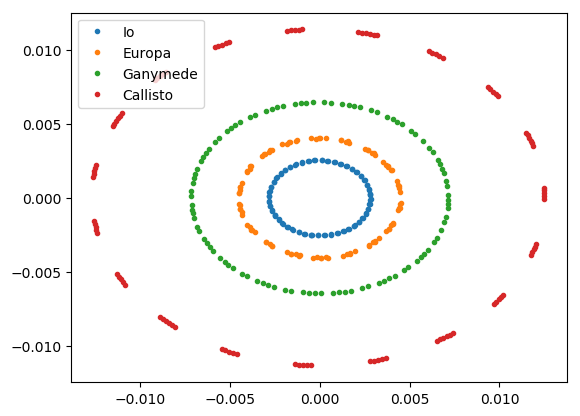

PyObject <matplotlib.legend.Legend object at 0x7f7c9f3dc7f0>

In [7]:
plot(pva_IO[1,:],pva_IO[2,:],".",label="Io")
plot(pva_EUR[1,:],pva_EUR[2,:],".",label="Europa")
plot(pva_GAN[1,:],pva_GAN[2,:],".",label="Ganymede")
plot(pva_CAL[1,:],pva_CAL[2,:],".",label="Callisto")
# plot(n_obs[1].*range(0,stop=0.01,length=100),n_obs[2].*range(0,stop=0.01,length=100))
legend()

In [6]:
n_obs=calc_obs_loc(pva_IO[1:3],pva_IO[4:6],pva_EUR[1:3],pva_EUR[4:6])

3-element Vector{Float64}:
  0.2600430378139754
 -0.8730914157196744
 -0.4124184747087524

Find observed transit time $t_{obs}$ (O) using JPL Ephemeris simulations 
(assuming that moons are co-planar, and from same observer)

In [7]:
# observed transit times: 
tt_IO=transit_times(naifId.id[:io],eph,times,1.769,1.0,n_obs,10);
tt_EUR=transit_times(naifId.id[:europa],eph,times,3.551,1.0,n_obs,10);
tt_GAN=transit_times(naifId.id[:ganymede],eph,times,7.155,1.0,n_obs,10);
tt_CAL=transit_times(naifId.id[:callisto],eph,times,16.69,1.0,n_obs,10);

In [8]:
# add some level of Gaussian error: (assume same error for all moons)
sigIO=fixed_noise(tt_IO,30);
sigEUR=fixed_noise(tt_EUR,30);
sigGAN=fixed_noise(tt_GAN,30);
sigCAL=fixed_noise(tt_CAL,30);

Perform linear regression, given guess of period from median of transit times

In [6]:
using Statistics
P1_est = median(tt_IO[2:end] - tt_IO[1:end-1])
P2_est = median(tt_EUR[2:end] - tt_EUR[1:end-1])
P3_est = median(tt_GAN[2:end] - tt_GAN[1:end-1])
P4_est = median(tt_CAL[2:end] - tt_CAL[1:end-1])
println("Period Estimates:")
println(P1_est,'\n',P2_est,'\n',P3_est,'\n',P4_est)

Period Estimates:
1.769131838111207
3.55112302582711
7.154500112403184
16.68901339545846


In [117]:
#Period values from PlanetBodyData.pdf
# 1.769
# 3.551
# 7.155
# 16.69

In [9]:
x_io,t0_io,per_io=linear_fit(tt_IO,1.769,sigIO)
x_eur,t0_eur,per_eur=linear_fit(tt_EUR,3.551,sigEUR)
x_gan,t0_gan,per_gan=linear_fit(tt_GAN,7.155,sigGAN)
x_cal,t0_cal,per_cal=linear_fit(tt_CAL,16.69,sigCAL)

([1.0 1.0 … 1.0 1.0; 0.0 1.0 … 218.0 219.0], 2.4430097992501836e6, 16.68901401739218)

In [8]:
println("Period from regression:")
println(per_io,'\n',per_eur,'\n',per_gan,'\n',per_cal)

Period from regression:
1.7691377497271785
3.551181052916602
7.154552531548235
16.68901401739218


In [49]:
(1/per_io) - (3/per_eur) + (2/per_gan)

3.1322111015974485e-8

In [14]:
println("Period Ratios from linear regression of observed transit times")
println("    Europa-Io: ",per_eur/per_io)
println("    Ganymede-Europa: ",per_gan/per_eur)
println("    Ganymede-Io: ",per_gan/per_io)
println("    Callisto-Ganymede: ",per_cal/per_gan)
println("    Callisto-Europa: ",per_cal/per_eur)
println("    Callisto-Io: ",per_cal/per_io)

Period Ratios from linear regression of observed transit times
    Europa-Io: 2.0072948267958415
    Ganymede-Europa: 2.014696638931481
    Ganymede-Io: 4.044090140890131
    Callisto-Ganymede: 2.3326425997714635
    Callisto-Europa: 4.699567205587958
    Callisto-Io: 9.433416939956098


Period ratios for Io-Europa-Ganymede are near integer values (1:2:4). Close to resonances, a combination of changes in semi-major axis and eccentricity leads to TTV cycles whose periods depend on the seperation from resonance.

In [15]:
# transit number (or Epoch) is second column of x
nt_io=x_io[2,:]
nt_eur=x_eur[2,:]
nt_gan=x_gan[2,:]
nt_cal=x_cal[2,:];

Compute calculted linear transit times (C) assuming constant period (i.e. the linear empheris)

$t_{calc} = t_{0} + Per \times E$  

In [10]:
tt0_IO  = collect(t0_io .+ per_io .* range(0,stop=length(tt_IO)-1,length=length(tt_IO))) ;
tt0_EUR  = collect(t0_eur .+ per_eur .* range(0,stop=length(tt_EUR)-1,length=length(tt_EUR))) ;
tt0_GAN  = collect(t0_gan .+ per_gan .* range(0,stop=length(tt_GAN)-1,length=length(tt_GAN))) ;
tt0_CAL  = collect(t0_cal .+ per_cal .* range(0,stop=length(tt_CAL)-1,length=length(tt_CAL))) ;

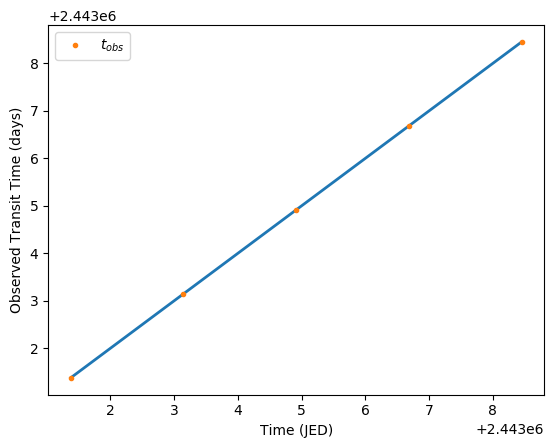

PyObject <matplotlib.legend.Legend object at 0x7f83ca795ba8>

In [128]:
# # Zoomed in on 5 points
# plot(t_io[1:5], t_io[1:5])
# plot(t_io[1:5], tt_IO[1:5],".",label=L"t_{obs}")
# xlabel("Time (JED)")
# ylabel("Observed Transit Time (days)")
# legend()

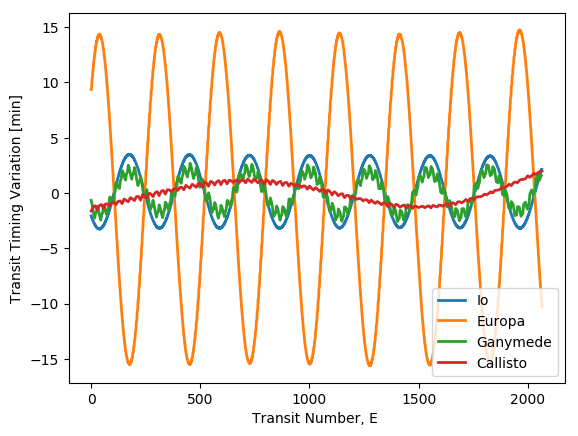

PyObject <matplotlib.legend.Legend object at 0x7f7ca1174cc0>

In [52]:
using PyPlot
rc("font",family="sans-serif")
rc("lines",linewidth=2)
plot((t_io.-t0_io)/per_io,(tt_IO.-t_io).*24*60,label="Io")
plot((t_eur.-t0_eur)/per_io,(tt_EUR.-t_eur).*24*60,label="Europa")
plot((t_gan.-t0_gan)/per_io,(tt_GAN.-t_gan).*24*60,label="Ganymede")
plot((t_cal.-t0_cal)/per_io,(tt_CAL.-t_cal).*24*60,label="Callisto")
xlabel("Transit Number, E ")
ylabel("Transit Timing Variation [min]")
legend()

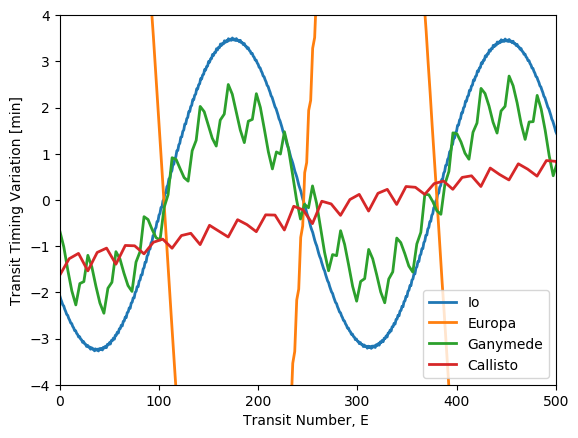

PyObject <matplotlib.legend.Legend object at 0x7f7ca1a44908>

In [55]:
plot((t_io.-t0_io)/per_io,(tt_IO.-t_io).*24*60,label="Io")
plot((t_eur.-t0_eur)/per_io,(tt_EUR.-t_eur).*24*60,label="Europa")
plot((t_gan.-t0_gan)/per_io,(tt_GAN.-t_gan).*24*60,label="Ganymede")
plot((t_cal.-t0_cal)/per_io,(tt_CAL.-t_cal).*24*60,label="Callisto")
xlabel("Transit Number, E ")
ylabel("Transit Timing Variation [min]")
ylim(-4,4)
xlim(0,500)
legend()

Io, Europa, and Ganymede vary on same timescale (the fact that all three vary together is related to the Laplace resonance) as expected for pairs of planetary satellites.

TTVs of Io and Ganymede are anti-correlated with those of Europa (conservation of energy within the system)

TTVs on Europa are larger than others because Io and Ganymede (it's adjacent bodies) are more massive than Europa.

Callisto's TTVs are on a longer timescale (Q: why?)

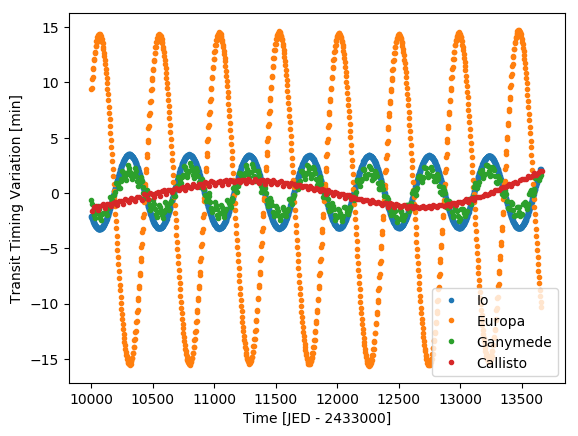

PyObject <matplotlib.legend.Legend object at 0x7f83cb843f60>

In [138]:
# same plot as above
plot((t_io.-2433000.0),(tt_IO.-t_io).*24*60,".",label="Io")
plot((t_eur.-2433000.0),(tt_EUR.-t_eur).*24*60,".",label="Europa")
plot((t_gan.-2433000.0),(tt_GAN.-t_gan).*24*60,".",label="Ganymede")
plot((t_cal.-2433000.0),(tt_CAL.-t_cal).*24*60,".",label="Callisto")
xlabel("Time [JED - 2433000]")
ylabel("Transit Timing Variation [min]")
legend()

In [19]:
println("Semi-amplitude of transit time variations (i.e. maximum absolute value)")
println("Io: ",maximum(abs.(tt_IO.-t_io).*24*60))
println("Europa: ",maximum(abs.(tt_EUR.-t_eur).*24*60))
println("Ganymede: ",maximum(abs.(tt_GAN.-t_gan).*24*60))
println("Callisto: ",maximum(abs.(tt_CAL.-t_cal).*24*60))

Semi-amplitude of transit time variations (i.e. maximum absolute value)
Io: 3.505655899643898
Europa: 15.64267449080944
Ganymede: 2.6806439459323883
Callisto: 1.979295238852501


want minimum of $\chi^2 \equiv \sum \frac{(t_{model} - t_{obs})^2}{\sigma^2}$

In [10]:
tt=[tt_IO;tt_EUR;tt_GAN;tt_CAL]
sigtt=[sigIO;sigEUR;sigGAN;sigCAL];
tt0=[tt0_IO;tt0_EUR;tt0_GAN;tt0_CAL];
nt1,nt2,nt3,nt4=2065,1030,511,220

(2065, 1030, 511, 220)

In [24]:
sat1 = PlanetTimes(tt_IO,tt0_IO)
sat2 = PlanetTimes(tt_EUR,tt0_EUR)
sat3 = PlanetTimes(tt_GAN,tt0_GAN);

In [11]:
using TTVFaster
p1=TTVFaster.Planet_plane_hk(log10(3e-5),per_io,t0_io,0.01,0.01)
p2=TTVFaster.Planet_plane_hk(log10(3e-5),per_eur,t0_eur,0.01,0.01)
p3=TTVFaster.Planet_plane_hk(log10(3e-5),per_gan,t0_gan,0.01,0.01)

Planet_plane_hk{Float64}(-4.522878745280337, 7.154552531548235, 2.4430037545135645e6, 0.01, 0.01)

In [85]:
t0_gan

2.4430037545135645e6

In [21]:
# Okay,now let's do a 4-moon fit:
# param_names = mass ratio,period,initial transit time,e*cos(omega),e*sin(omega)
init_param = [log10(3e-5),per_io,t0_io,0.01,0.01,
            log10(3e-5),per_eur,t0_eur,0.01,0.01,
            log10(3e-5),per_gan,t0_gan,0.01,0.01,
            log10(3e-5),per_cal,t0_cal,0.01,0.01]
println("Initial parameters: ",init_param)

Initial parameters: [3.0e-5, 1.7691377497271785, 2.4430013760673758e6, 0.01, 0.01, 3.0e-5, 3.551181052916602, 2.4430015719061797e6, 0.01, 0.01, 3.0e-5, 7.154552531548235, 2.4430037545135645e6, 0.01, 0.01, 3.0e-5, 16.68901401739218, 2.4430097992501836e6, 0.01, 0.01]


below cells won't work because bug.

In [22]:
using TTVFaster
# Set up data structure to hold planet properties,passed to TTVFaster
jmax = 5
data=init_param
p1=TTVFaster.Planet_plane_hk(data[1],data[2],data[3],data[4],data[5])
p2=TTVFaster.Planet_plane_hk(data[6],data[7],data[8],data[9],data[10])
p3=TTVFaster.Planet_plane_hk(data[11],data[12],data[13],data[14],data[15])
p4=TTVFaster.Planet_plane_hk(data[16],data[17],data[18],data[19],data[20])
# assuming no transits are skipped/duplicated ########### To Change
time1 = collect(p1.trans0 .+ range(0,stop=nt1-1,length=2065) .* p1.period)
time2 = collect(p2.trans0 .+ range(0,stop=nt2-1,length=1030) .* p2.period)
time3 = collect(p3.trans0 .+ range(0,stop=nt3-1,length=511) .* p3.period)
time4 = collect(p4.trans0 .+ range(0,stop=nt4-1,length=220) .* p4.period)
##########
# Initialize the computation of the Laplace coefficients:
ttv1 = zeros(nt1)
ttv2 = zeros(nt2)
ttv3 = zeros(nt3)
ttv4 = zeros(nt4)
# # Need first call to TTVFaster,without optimizing; Q: why?
# dummy=TTVFaster.compute_ttv!(jmax,p1,p2,time1,time2,ttv1,ttv2)

In [37]:
ntrans=+(nt1,nt2,nt3,nt4)

3826

In [40]:
function new_wrapper(tt0::Vector{Float64},nplanet::Int64,ntrans::Vector{Int64},params::Vector{T},jmax::Integer) where T<:Real
  # These lines need modification for different choices of parameters:
  n1,n2,n3,n4 = ntrans[1:4]
  # println(n1, " ", n2)

  # Call ttv_nplanet:
  ttv = TTVFaster.ttv_nplanet(nplanet,jmax,ntrans,params[1:5*nplanet])
  # We measure transit times,not TTVs,so add back in the linear ephemeris:
  per1 = params[2]; t01 = params[3]
  tt1 = collect(range(t01,stop = t01+per1*(n1-1),length = n1)) 
  for i=1:n1
    tt1[i]+= ttv[1,i]
  end
  per2 = params[7];  t02 = params[8]
  tt2 = collect(range(t02,stop = t02+per2*(n2-1),length = n2)) 
  for i=1:n2
    tt2[i] += ttv[2,i]
  end
  per3 = params[7];  t03 = params[8]
  tt3 = collect(range(t03,stop = t03+per3*(n3-1),length = n3)) 
  for i=1:n3
    tt3[i] += ttv[2,i]
  end
  per4 = params[7];  t04 = params[8]
  tt4 = collect(range(t04,stop = t04+per4*(n4-1),length = n4)) 
  for i=1:n4
    tt4[i] += ttv[2,i]
  end
  # If transit times of additional planets were observable these would need to be added in.
  return [tt1;tt2;tt3;tt4]  
end


function chisquare(tt0,nplanet,ntrans,params,tt,sigtt,jmax)
  chisq = 0.0  
  # println(params,tt[1],sigtt[1])
  tt_model = new_wrapper(tt0,nplanet,ntrans,params,jmax)
println(length(tt_model))
  for j=1:length(tt)
    chisq += (tt[j]-tt_model[j])^2/sigtt[j]^2
  end
  return chisq
end

chisquare (generic function with 2 methods)

In [42]:
# Now,optimize 2-planet fit
ntrans = [nt1,nt2,nt3,nt4]
Nobs = sum(ntrans)
nplanet = 4
nparam=20
println("Initial chi-square: ",chisquare(tt0,nplanet,ntrans,init_param,tt,sigtt,jmax))

3826
Initial chi-square: 9.883184207414906e15


need to modify params[1]^10()init_param

In [48]:
using LsqFit
weight = ones(nt1+nt2+nt3+nt4)./ sigtt.^2 #assigns each data point stat weight d.t. noise = 1/σ^2
param1 = init_param .+ 100.0
niter = 0
while maximum(abs.(param1 .- init_param)) > 1e-5 && niter < 20
param1 = init_param
res = curve_fit((tt0,params) -> new_wrapper(tt0,nplanet,ntrans,params,jmax),tt0,tt,weight,init_param)
init_param = res.param
niter += 1
# println("init_param: ",init_param)
println("New Initial chi-square: ",chisquare(tt0,nplanet,ntrans,init_param,tt,sigtt,jmax))
end
println("New initial 2-planet fit: ",init_param," in ",niter," iterations.")

3826
New Initial chi-square: 7.046151992131085e15
New initial 2-planet fit: [0.0003829228242708581, 1.7693385978160507, 2.4430057685665046e6, -0.5329173730585521, -1.9935334258711965, 9.961154518729788e-6, 3.562465689604765, 2.4432278699825895e6, -9.550147832497753, 0.3319387081678243, -0.00011354075532146714, 7.148286174277158, 2.442996465415287e6, 28.432318820703102, -1.4023997322104165, -1.1416142827602947e-5, 16.668779431964293, 2.439583316609653e6, -16891.34478717736, 149.89576075005078] in 1 iterations.


In [ ]:
fit = curve_fit((tt0,params) -> new_wrapper(tt0,nplanet,ntrans,params,jmax),tt0,tt,weight,init_param)
cov=estimate_covar(fit)
err=[sqrt(cov[i,j]) for i=1:nparam, j=1:nparam if i==j ]
best_p2 = fit.param ##### is this the global p2 fit???
ttmodel = ttv_wrapper(tt0,nplanet,ntrans,best_s4,jmax,true)
lprob_best_p2= (1 - Nobs/2) * log(sum((tt-ttmodel).^2 ./sigtt.^2))
# println("Finished 2-planet fit") 
println("New 4-moon chi-square: ",chisquare(tt0,nplanet,ntrans,best_p2,tt,sigtt,jmax))
println("Maximum: ",lprob_best_p2," Param: ",best_p2)

Resonances are identified by looking at the resonant arguments, which are defined as: 
   $$ \theta = (p + q)\lambda_{\rm out} - p \lambda_{\rm in} - q \omega_{\rm out/in}$$
 where $\lambda_{\rm out}$ and $\lambda_{\rm in}$ are the mean longitudes of the outer and inner bodies, respectively,
 and $\omega_{\rm out}$ is the longitude of pericenter of the outer/inner body.
 The ratio of periods is defined as : $$P_{\rm in}/P_{\rm out} ~= p / (p + q)$$

 If the resonant argument, $\theta$, oscillates but is constrained within some range of angles, then 
 there is a resonance between the inner and outer bodies. We call this libration of the angle $\theta$. 
 The trick is to find what the values of q and p are.  For our case, we can easily see that 
 there are two 2:1 resonances between the moons, so their resonant arguments would follow 
 the function:
    $$\theta = 2 \lambda_{\rm out} - \lambda_{\rm in} - \omega_{\rm out}$$

 To make the plotting easier, we can borrow this helper function that puts angles into 0 to 360 degrees 
 from another example (Fourier analysis & resonances), and define a new one that puts angles
 into -180 to 180 degrees.

### Testing Week

In [27]:
using CALCEPH
# create an ephemeris context
# prefetch ephemeris files data to main memory for faster access
eph = Ephem("jup365.bsp");prefetch(eph)
# eph2=Ephem("de440.bsp");prefetch(eph2)

In [28]:
# retrieve the position, velocity and acceleration of Jupiter (geocenter) relative
# to the Jupiter system barycenter in kilometers, kilometers per second and
# kilometers per second square at JD= 2451624.5 TDB timescale
# for best accuracy the first time argument should be the integer part and the
# delta the fractional part
# when using NAIF identification numbers, useNaifId has to be added to
# the units argument.
options=useNaifId+unitKM+unitDay
# compute(eph,jd1,time,target,center)
# compute pos, vel, and accel of target with respect to center at epoch jd + time 
pva=compute(eph,2451624.0,0.0,naifId.id[:jupiter],naifId.id[:jupiter_barycenter],options,2)

9-element Vector{Float64}:
  -56.78959460793486
  120.01036243773541
   56.127075558016415
 -164.76240461705203
    7.6569951722362495
    1.5288281126255125
  -66.17476086280743
 -307.8609219703632
 -147.34411689686902

In [36]:
position=pva[1:3]; velocity=pva[4:6]; acceleration=pva[7:end]

3-element Vector{Float64}:
 -0.0001475682207194388
  0.0002142302410580049
  9.77498117209723e-5

In [35]:
println("pos=", position, "vel=", velocity, "accel=",acceleration) # KM/Day

pos=[358639.4430215482, -520603.32592385175, -237544.5480735013]vel=[11.619864984728496, 6.428408900767614, 3.181863494169955]accel=[-0.0001475682207194388, 0.0002142302410580049, 9.77498117209723e-5]


In [23]:
nyear=10
# julian date 
jd_start=2443000.0; jd_end=jd_start + nyear*365.25; jdsize=100
times=range(jd_start, stop=jd_end, length=jdsize)

2.443e6:36.89393939393939:2.4466525e6

In [24]:
pva_IO=zeros(9, jdsize)
pva_EUR=zeros(9, jdsize)
pva_GAN=zeros(9, jdsize)
pva_CAL=zeros(9, jdsize)

9×100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [29]:
for i=1:length(times)
    pva_IO[1:9,i] = compute(eph,times[i],0.0,naifId.id[:io],naifId.id[:jupiter],options,2)
    pva_EUR[1:9,i] = compute(eph,times[i],0.0,naifId.id[:europa],naifId.id[:jupiter],options,2)
    pva_GAN[1:9,i] = compute(eph,times[i],0.0,naifId.id[:ganymede],naifId.id[:jupiter],options,2)
    pva_CAL[1:9,i] = compute(eph,times[i],0.0,naifId.id[:callisto],naifId.id[:jupiter],options,2)
end

In [30]:
pva_IO

9×100 Matrix{Float64}:
      4.20637e5        2.8784e5   …  -65825.0        -370894.0
  33687.2        -280176.0               -3.7726e5        -1.81505e5
  22984.9             -1.28963e5         -1.80735e5   -92468.4
     -1.37097e5        1.09882e6          1.47339e6        7.15133e5
      1.34433e6        9.11071e5         -2.19846e5       -1.18774e6
 639340.0              4.52869e5  …  -80634.3        -553980.0
     -5.27404e6       -3.62781e6          8.20289e5        4.63252e6
     -4.22413e5        3.53116e6          4.70152e6        2.26704e6
     -2.88209e5        1.62536e6          2.25237e6        1.15495e6

In [21]:
tt=[2430000.5,2432000.5,2434000.5]

3-element Vector{Float64}:
 2.4300005e6
 2.4320005e6
 2.4340005e6

In [33]:
sigtt=fixed_noise(tt,30)

3-element Vector{Float64}:
 0.00034722222222222224
 0.00034722222222222224
 0.00034722222222222224

In [45]:
for i=1:length(sigtt)
    if sigtt[i]==0.0 || sigtt[i]<=0
        println("BAD")
    end
end

In [47]:
using Random,Distributions

In [105]:
noise=rand(Normal(0,(sigma / (24 * 3600)) ),length(tt))

3-element Vector{Float64}:
 -0.00042453260894759806
 -9.47746280665391e-5
  0.00018406219653271206

In [106]:
noise.+tt

3-element Vector{Float64}:
 2.4300004995754673e6
 2.4320004999052254e6
 2.4340005001840624e6

In [91]:
using Statistics
std(sigtt)

0.0

In [94]:
std(tt)

2000.0

In [70]:
noise=randn(length(tt)).*ones(length(tt)) * sigma / (24 * 3600) # sigma in seconds,sigtt in days


3-element Vector{Float64}:
  0.00013068724709292004
 -0.0010432152256497635
  2.266316018641206e-5